# Sampling Fram Bridges - SBB Project


In [31]:
from skopt.sampler import Lhs, Sobol
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import time
import math as m

### Problem Definition

Input Parameter/ Deisgn Features:
- b1: Length of Wall 1 [m]: 5,35
- b2:

## Utils

In [32]:

def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        try:
            os.makedirs(folder_path)
            print(f"Folder '{folder_path}' created successfully.")
        except OSError as e:
            print(f"Error creating folder '{folder_path}': {e}")

In [47]:
def hist_matrix(df, n_cols=4, bins=20, color='gray', edgecolor='darkgray'):
    # Number of columns in the DataFrame
    n_columns = len(df.columns)

    # Number of histogram columns per row
    n_cols = 4

    # Calculate the number of rows needed
    n_rows = m.ceil(n_columns / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 2.5))  # Adjust the figsize as needed
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        # Plot histogram on the corresponding subplot
        axes[i].hist(df[column], bins=bins, color=color, edgecolor=edgecolor)  # You can customize the histogram here
        axes[i].set_title(f'Histogram of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(False)  # Optional: Remove grid lines

    # Hide any empty subplots if the number of columns is less than n_rows*n_cols
    for ax in axes[len(df.columns):]:
        ax.axis('off')

    plt.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.show()  # Display the histograms

## Sampling

In [33]:
n_samples=1000 #number of samples that should be generated
idx_s=200 # Smapling iteration


In [34]:
# Save idx_s in a CSV file (as comunication with GH) + create folders

# create path relative to yurrent directory (=the directory of the notebook file)
current_directory = os.getcwd()
folder_name='CFBData'
folder_path = os.path.join(current_directory, folder_name)

# define/check/ create main folder
#folder_path='C:\CFBData'

create_folder_if_not_exists(folder_path)
#TODO deleate all subfolders in that folder

# check/ create subfolder
subfolder = '{}_Batch'.format(idx_s)
subfolder_path = folder_path+ '\\' +subfolder
create_folder_if_not_exists(subfolder_path)

# create subfolders for each bridge
for i in range(n_samples):
    indiv_path= subfolder_path + '\\{}_{}_CFB'.format(idx_s,i)
    create_folder_if_not_exists(indiv_path)
# # create file with sampling iteration index (functioning as communication file)
# idx_file = subfolder_path + '\current_idx_s.csv'
# df_idx_s = pd.DataFrame([idx_s], columns=['idx_s'])
# df_idx_s.to_csv(idx_file, index=False)  # Save idx_s CSV file

In [49]:
# define file path
#folder= 'C:\\Temp\\00_Sampled'


# define ranges of design parameter
#----- geometric parameter (global) --------
# Main geometry
L =  (3000.,8000.)     # Span [mm]
b1 = (8000.,20000.)     # With of Wall 1 [mm]
t_p = (200.,800.)      # Plate Thickness [mm]

t_w = (200., 800.)    # Wall Thickness [mm]
h_w = (2000.,5000.)    # Wall Hight [mm]


main_names = ['L','b1','t_p','t_w','h_w']
main=[L,b1,t_p,t_w,h_w]


#----- geometric parameter per section ---------
# Reinforcement diamater and spacing

#plate
#d1_plate= (10,12,14,16,18,20,22,26,30) # Reinforcement Diameter of all plate sections - Layer 1 (lowest layer) [mm]
d1_plate=(10.,30.)
# (10,12,14,16,18,20,22,26,30) (10.,30.)
#d4_plate= (10,12,14,16,18,20,22,26,30) # Reinforcement Diameter of all plate sections - Layer 4 (top layer) [mm]
d4_plate=(10.,30.)
# (10,12,14,16,18,20,22,26,30) (10.,30.)
#s_plate= (75,100,150,200,250) # Reinforcement Spacing of plate  - all Layers [mm]
s_plate=(75.,250.)
#(75,100,150,200,250)(75,250)

#walls
#d1_walls= (10,12,14,16,18,20,22,26,30) # Reinforcement Diameter of all wall sections - Layer 1 (inner layer) [mm]
d1_walls=(10.,30.)
# (10,12,14,16,18,20,22,26,30)
#d4_walls= (10,12,14,16,18,20,22,26,30) # Reinforcement Diameter of all wall sections - Layer 4 (outer layer) [mm]
d4_walls=(10.,30.)
# (10,12,14,16,18,20,22,26,30)
#s_walls= (75,100,150,200,250) # Reinforcement Spacing of walls  - all Layers [mm]
s_walls=(75.,250.)
#(75,100,150,200,250)


reinf=[d1_plate, d4_plate, s_plate, d1_walls, d4_walls, s_walls]
reinf_names = ['d1_plate','d4_plate','s_plate','d1_walls','d4_walls','s_walls']



#----- material parameter--------

# concrete parameter (at first constant for whole structure)
# sampling of fcd --> fck berechnen und dann ecu
#fcc = (40.,90.) # fck [MPa] taken from EN 1992-1-1:2004 (Table 3.1) (charakteristischer Wert der Zylinderdruckfestigkeit)
# (40,45,50,55, 60,70,80,90) chosen continous as for exiting structured there could be material tests
fcc = (10.,90.)
# ecu is calculated based on fcc (after sampling, see below)

# steel
fsy = (500., 700.) # MPa / N/mm2 Fliessgrenze von Betonstahl (chosen continous as for exiting structured there could be material tests)
fsu_fac = (1.0, 2.0) # larger than fsy, but continously larger (--> daher sample ich mit einem Faktor)
# fsu = (850., 850.001) # Duktilitätsgrenze

          
          
matPar = [fcc, fsy, fsu_fac]
matPar_names = ['fcc', 'fsy', 'fsu_fac']


# ----- loading parameter -----------
s = (0., 1.) # Distance factor of railway track
beta = (-89., 89.) # angle of railway track


loadPar = [s, beta]
loadPar_names = ['s', 'beta']



In [50]:
# idea make a sample space library (dict) 
#sodass man diesen nicht immer neu definieren muss (da es so viele Parameter sind ist das extrem nerfig)
# und es sollte leich sein andere sampling methoden (gleiche b1 =b2 oder einheitliche bewehrung zu samplen, oder gerade sections)
# bei schrägen brücken auch oft gerade sections unterteilungen. zurzeit nicht so einfach möglich so zu samplem
# aber mann kann tioretisch berechnen wie gross dann die anderen parameter sein müssen abhängig von b1 und b2 
# oder man kann die prior brücken parameter nehmen und aus der verteilung samplen...

# lieber mach ich pakete die man zusammenaddieren kann?

In [51]:
# define deisgn feature space
space =  main + reinf +matPar + loadPar
space_names = main_names  + reinf_names +matPar_names + loadPar_names

# space = [t_p]
# space_names = ['t_p',]

print(space)
print(space_names)
print(len(space_names))

[(3000.0, 8000.0), (8000.0, 20000.0), (200.0, 800.0), (200.0, 800.0), (2000.0, 5000.0), (10.0, 30.0), (10.0, 30.0), (75.0, 250.0), (10.0, 30.0), (10.0, 30.0), (75.0, 250.0), (10.0, 90.0), (500.0, 700.0), (1.0, 2.0), (0.0, 1.0), (-89.0, 89.0)]
['L', 'b1', 't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 'fsy', 'fsu_fac', 's', 'beta']
16


In [52]:
sampler=Sobol()
sampler.generate(space, n_samples,random_state=None)


c:\Users\kuhnso\AppData\Local\anaconda3\envs\strucenglib3\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1000=1000. 
  warnings.warn("The balance properties of Sobol' points require "


[[3987.9665339736257,
  9160.480530631245,
  613.5205828453636,
  749.8293008337982,
  4185.97065621492,
  15.745724502240641,
  12.793995858169067,
  88.89173876700946,
  20.607904681780948,
  17.714246154931477,
  236.8804559925659,
  75.64744273711354,
  545.9414448263783,
  1.2862097259658867,
  0.7490138760778448,
  -42.81672770150549],
 [6487.966533973626,
  15160.480530631245,
  313.5205828453636,
  449.82930083379824,
  2685.97065621492,
  25.74572450224064,
  22.79399585816907,
  176.39173876700946,
  10.607904681780948,
  27.714246154931477,
  149.38045599256594,
  35.64744273711355,
  645.9414448263783,
  1.7862097259658867,
  0.24901387607784464,
  46.1832722984945],
 [7737.966533973626,
  12160.480530631245,
  463.5205828453636,
  299.82930083379824,
  3435.97065621492,
  20.74572450224064,
  27.79399585816907,
  132.64173876700946,
  25.607904681780948,
  12.714246154931477,
  105.63045599256593,
  55.64744273711355,
  595.9414448263783,
  1.0362097259658867,
  0.99901387

In [53]:

# generate Samples - LHS
lhs=Lhs(lhs_type='classic', criterion='maximin', iterations=1000)
X=lhs.generate(space, n_samples, random_state=None)

# # generate Samples - Sobol --> Sample Space has to have less than 40 variables)
# sobol=Sobol()
# X=sobol.generate(space, n_samples, random_state=None)

# tranform into datafram
df_x=pd.DataFrame(X)
df_x.columns =  space_names # renaming columns

df_x.head(10)

,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,s_plate,d1_walls,d4_walls,s_walls,fcc,fsy,fsu_fac,s,beta
0,3264.911067,16765.132982,531.656436,621.775968,2604.161687,24.228625,13.427572,206.036846,20.171051,21.603165,154.791916,78.582066,661.687151,1.118215,0.466400,-19.795060
1,5361.115418,17451.415474,744.304389,275.279703,3820.154356,17.838816,12.481430,218.545430,10.168009,17.741306,224.591835,69.661242,643.156228,1.585713,0.101407,-43.518332
2,7197.928187,12610.611102,792.070735,496.244565,4273.476243,22.587214,26.028824,128.850732,24.508125,11.975247,219.277296,54.346391,672.847476,1.534787,0.534809,-60.119048
3,4946.728918,16364.414176,373.131286,477.965439,3363.099660,24.607351,29.281128,135.563137,15.921368,14.034145,93.621302,26.803076,580.390152,1.274187,0.291366,-26.389680
4,4940.337104,19145.252592,464.963852,412.443855,2135.646626,15.313616,16.445258,79.214303,27.700309,18.349838,122.330417,32.158550,619.612770,1.268089,0.329740,-52.651902
5,5001.251491,15433.006671,222.105558,309.910967,3399.889667,12.231035,28.075810,208.025337,27.373556,16.574013,197.382797,52.547878,641.548125,1.792849,0.529625,-57.693325
6,4414.089797,8312.092876,361.124863,451.282161,4276.008114,18.859086,22.140171,75.832021,15.014568,24.199286,122.000935,59.121721,536.920705,1.692291,0.570014,-62.817205
7,6432.827364,19375.663367,696.635598,332.631731,4207.122524,11.666500,22.051077,167.977917,17.969646,16.036232,109.925544,28.873052,657.736283,1.960808,0.646380,37.043206
8,5834.573008,9918.983973,665.533971,712.009033,2088.593590,27.335933,12.705222,167.182498,25.056930,16.589713,89.330362,55.129033,679.140238,1.030285,0.847942,-12.062158
9,5611.705759,11686.690989,412.941515,329.308096,2883.128736,28.358411,17.982783,240.294757,13.419343,20.214675,183.697298,51.007354,575.589634,1.591356,0.656332,48.404726


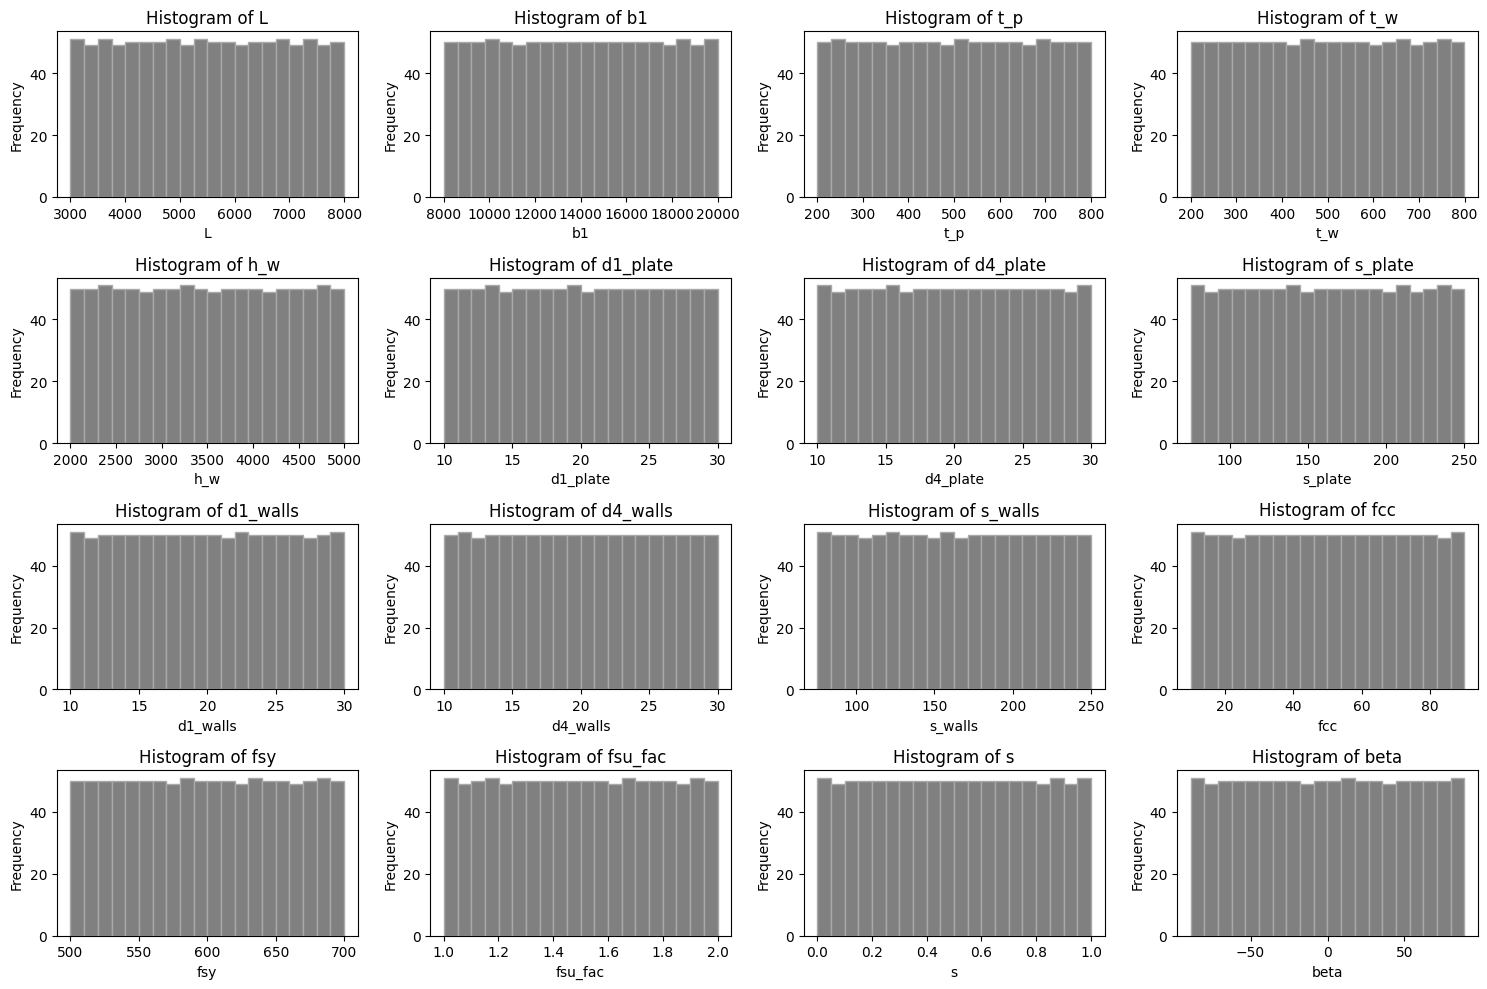

In [54]:
hist_matrix(df_x, n_cols=4, bins=20, color='gray', edgecolor='darkgray')

In [419]:
# # Generate ordered samples
# v=np.linspace(beta[0], beta[1], n_samples)
# df_v=pd.DataFrame(v, columns=['beta'])
# df_v.head(10)

,beta
0,-89.000000
1,-69.222222
2,-49.444444
3,-29.666667
4,-9.888889
5,9.888889
6,29.666667
7,49.444444
8,69.222222
9,89.000000


In [55]:
# define a specific sample to be caluclated
hero_parameters = {
    'L': 5800,
    'b1': 9720,
    't_p': 400,
    't_w': 400,
    'h_w': 2580,
    'd1_plate': 24,
    'd4_plate': 24,
    's_plate': 200,
    'd1_walls': 14,
    'd4_walls': 24,
    's_walls': 200,
    'fcc': 12.8,
    'fsy': 390,
    'fsu_fac': 1.85,
    's': 0.18179012,
    'beta': 5
}

# # Convert the dictionary to a DataFrame
# hero_parameters = {key: [value] for key, value in hero_parameters.items()}
# df_x = pd.DataFrame(hero_parameters)#, columns=list(hero_parameters.keys()))

# # Print the DataFrame
# df_x

In [421]:
# create multiple samples with only one variable varied

# for key in hero_parameters.keys():
#     df_v[key]=hero_parameters[key]
# df_x=df_v

In [422]:
# Make it easyer to do these 3 options: Sampler with lhc/ sobol with alot of paramters, line space sampling for one parameter, Define all variables for a sample

# TODO: idea to make sampling cleaner: write a function that does the sampling, the defining of constants in the background,
# define a dict with all possible parameters and their ranges
# default sample everything (maybe ability presetting Step 1.1. etc)
# can provide reduced list of parameters
# can also provide a dict with fixed parameters (which are then excluded from samling)
# also a way to set some parameters equivalent to other parameters after sampling
# some are calculated after sampling
# should always return df in same column order (for that we however we need to fix the columns add I think I will add more for step 1.3)

In [56]:
# Materialkennwerte berechnen

# Concrete
# calculate dependent parameters
# fcc: Compressive strength of concrete
# ecu: Ultimate compressive strain in the concrete
def ecu_calc(fccs): # EN 1992-1-1:2004 (Table 3.1)
    return fccs.apply(lambda fcc: -0.002 if fcc <= 50 else ((2.0+0.085*(fcc-50)**(0.53)) *-0.001))

df_x['ecu']=ecu_calc(df_x['fcc']) 

# Reinforcement
df_x['fsu']=df_x['fsu_fac']*df_x['fsy'] #calculate fsu with sampled fsu factor multiplied with fsy

#print
df_x[['fcc','ecu','fsy','fsu']]

,fcc,ecu,fsy,fsu
0,78.582066,-0.002503,661.687151,739.908272
1,69.661242,-0.002412,643.156228,1019.861417
2,54.346391,-0.002185,672.847476,1032.677819
3,26.803076,-0.002000,580.390152,739.525804
4,32.158550,-0.002000,619.612770,785.724334
...,...,...,...,...
995,12.668855,-0.002000,582.031704,1052.592059
996,43.590406,-0.002000,588.933747,1085.108326
997,65.375573,-0.002362,683.733964,739.654408
998,77.449844,-0.002492,504.605455,862.778992


In [57]:
#define constant design variables for phase 1
# we still save all of these constant variables in the data set, to ensure: when we extend the model,
# we know these variables for each sample and combine the samples.

#----- geometric parameter (global) --------
# Main geometry
df_x['b2']=df_x['b1'] # With of Wall 2 [mm]
df_x['alpha_l']=90  # Plate Angle [Degree]

#plate parameter
df_x['l_sec'] = 0.33    # Proportion of outter plate sections [-]
# (0.1,0.45)

df_x['b_sec1_b1'] = 0.33 # Proportion of section 1 (wall 1 side) [-]
df_x['b_sec2_b1'] = 0.33 # Proportion of section 2 (wall 1 side) [-]
df_x['b_sec1_b2'] = df_x['b_sec1_b1'] # Proportion of section 1 (wall 2 side) [-]
df_x['b_sec2_b2'] = df_x['b_sec1_b2'] # Proportion of section 2 (wall 2 side) [-]
#(0.05,0.45)

# wall paraeter
df_x['h_S1_3'] = 0.33   # Proportion of wall section (upper)
df_x['h_S7_9'] = 0.33   # Proportion of wall section (lower)
#(0.05,0.45)

# vouten and parapet geometry parameter
df_x['h_v'] = 0       # Hight of Voute  [mm]
df_x['l_v'] = 0     # Length of Voute  [mm]

df_x['left_p'] = False   #Parapet on the left (at x=0)
df_x['right_p'] = False  #Parapet on the right (at x=b1)
df_x['h_b'] = 0        #Parapet height (Bruestungshöhe) [mm]
df_x['b_b'] = 0      # Parapet width [mm]


# vouPar_names = ['h_v','l_v','left_p','right_p','h_b','b_b']
# vouPar = [h_v,l_v,left_p,right_p,h_b,b_b]



#----- material parameter--------

df_x['esu'] = 0.05 # ultimate reinforcement strain [-]


#----- load parameter--------
df_x['h_G'] = 1000 #Gravel layer hight [mm]
df_x['gamma_E'] =0.00002 #spez. weight of backfill [N/mm3]
df_x['phi_k'] = 30 # friction angle [Degree]

df_x['q_Gl'] = 4.8+1.7 # Load of concrete sleeper (Betonschwelle) and rail track [N/mm]
df_x['b_Bs']= 2500 # width of concrete sleeper (Betonschwelle) [mm]
df_x['Q_k'] = 225000 # norminal axle load (dependent on the class, acc. to SIA 269/1 11.2, for D4 = 225 [N] )


# ---- structural modeling parameters -------
df_x['withMPCs'] = True     # with or without MPCs
df_x['offsetmodeling'] = True  #with or without offsetmodeling
df_x['mesh_size_factor'] = 3   # mesh_size_factor (multiplied with t_p or t_w respectively)

In [58]:
#----- reinforcement --------
# define constant variables

df_x['oo'] = 30 # upper reinforcement cover [mm]
df_x['uu'] = 30 # lower reinforcement cover [mm]


#reinf=[d1_plate, d4_plate, s_plate, d1_walls, d4_walls, s_walls]

#plate
df_x['d2_plate'] = 12 # Reinforcement Diameter of all plate sections - Layer 2 (lower middle layer) [mm]
df_x['d3_plate'] = 12 # Reinforcement Diameter of all plate sections - Layer 3 (upper middle layer) [mm]
# walls
df_x['d2_walls'] = 12 # Reinforcement Diameter of all wall sections - Layer 2 (inner middle layer) [mm]
df_x['d3_walls'] = 12 # Reinforcement Diameter of all wall sections - Layer 3 (outer middle layer) [mm]






C:\Users\kuhnso\AppData\Roaming\Python\Python39\site-packages\matplotlib\axes\_axes.py:6639: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


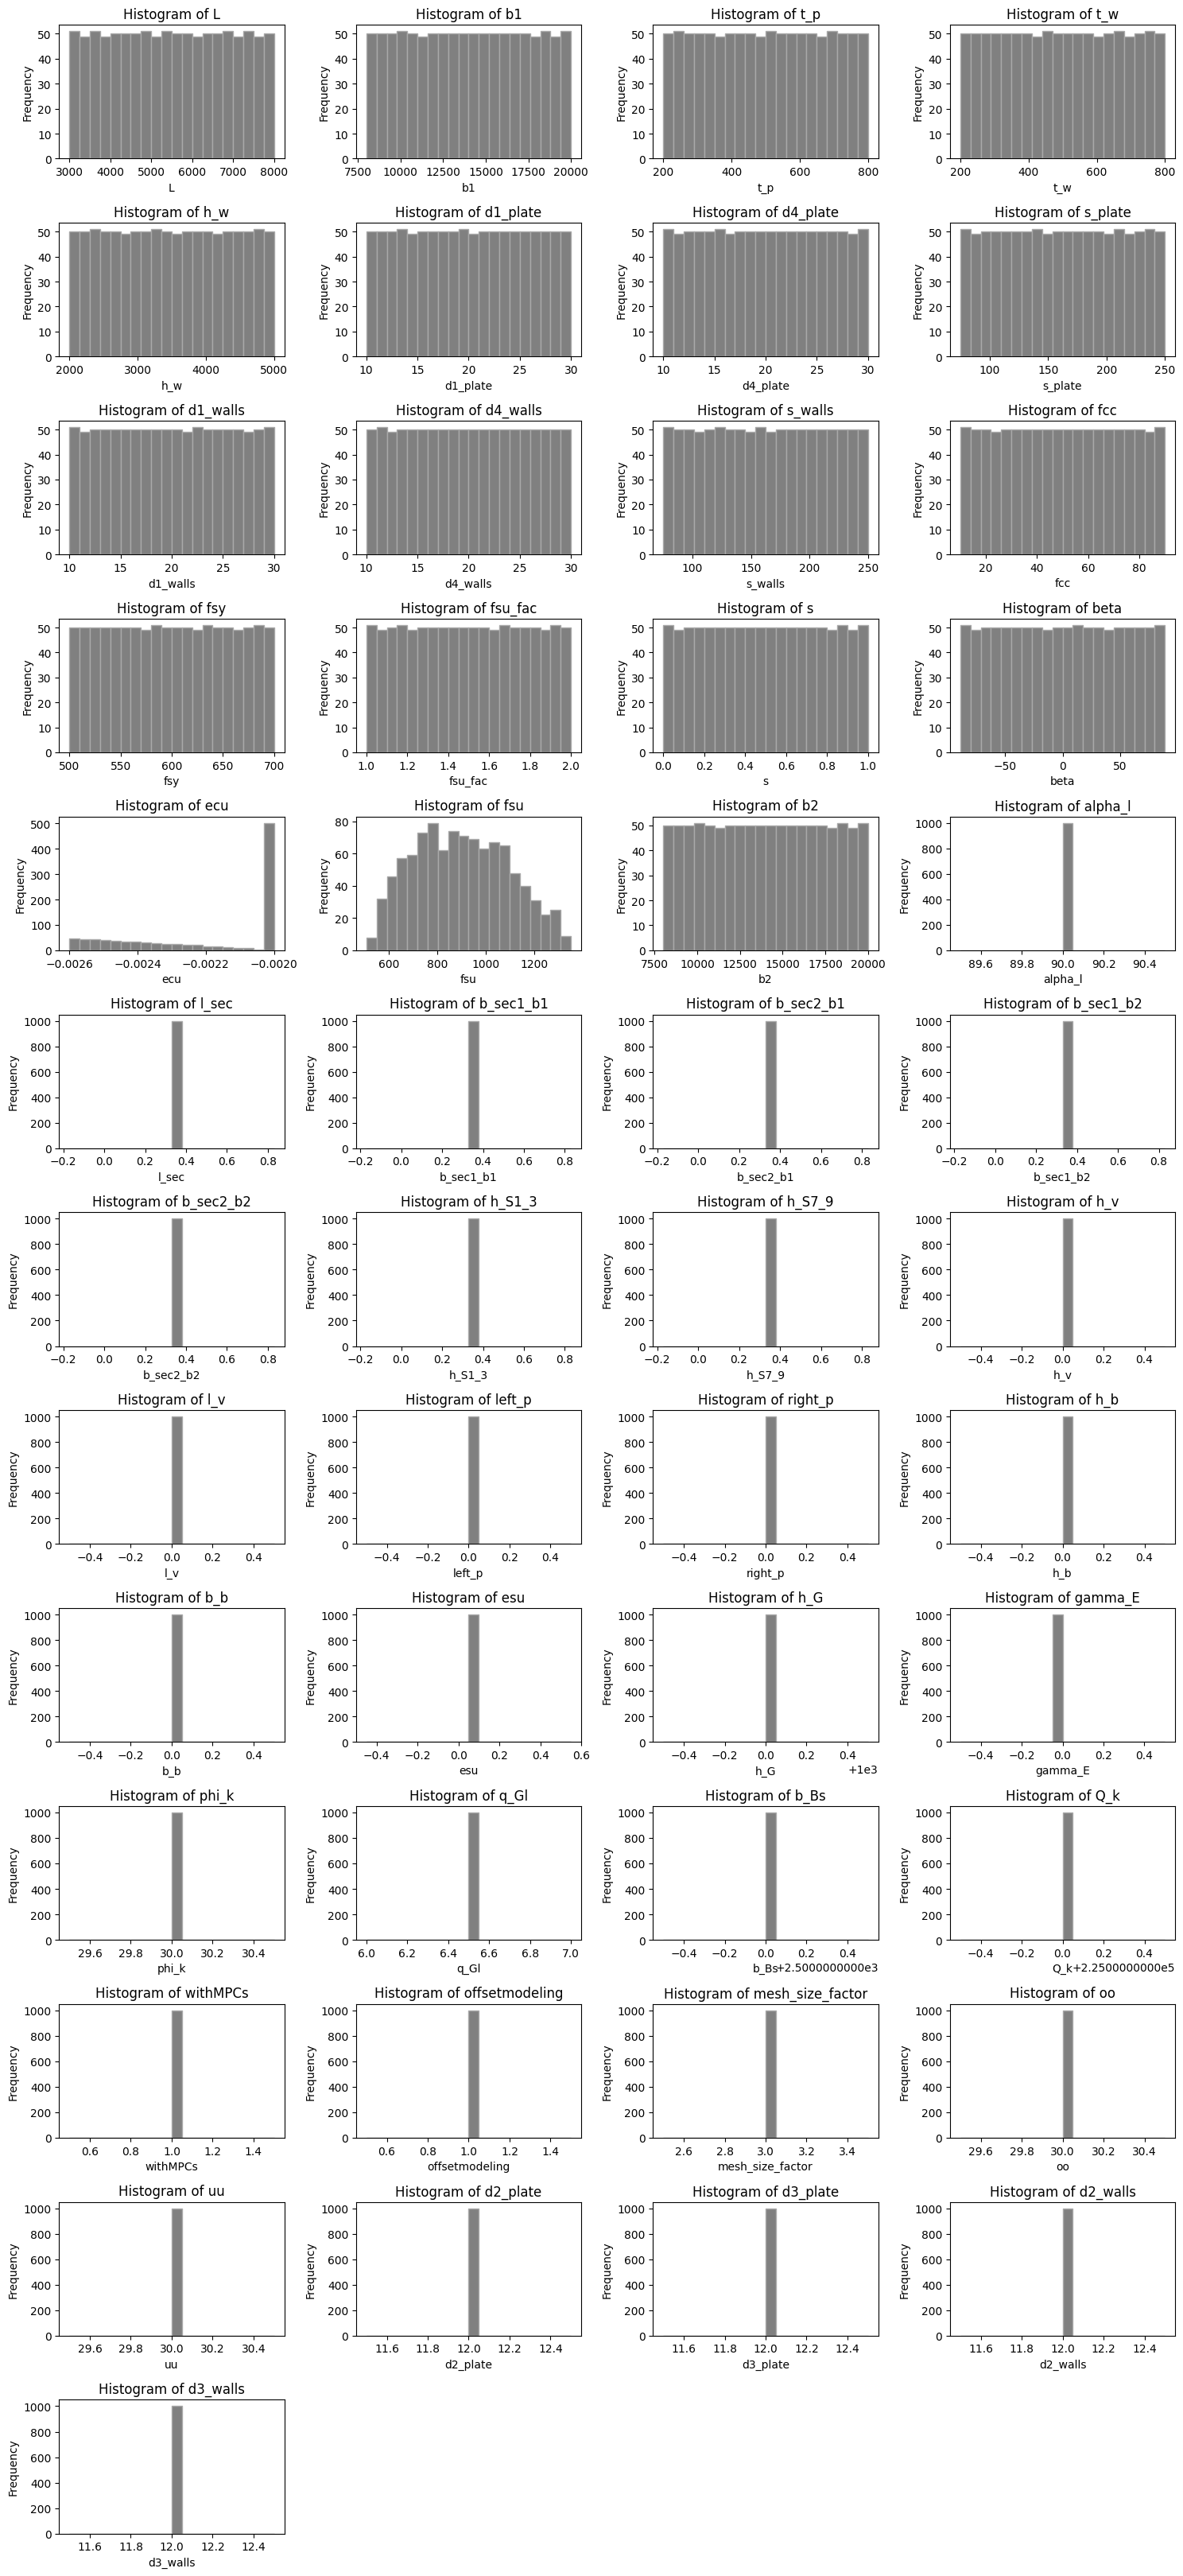

In [59]:
hist_matrix(df_x, n_cols=4, bins=20, color='gray', edgecolor='darkgray')

In [60]:
# assign the reinforcements for each individual section
for i in range (1,9+1):
    print('i',i)
    # plate
    df_x['d1_plate_s{}'.format(i)]=df_x['d1_plate']
    df_x['d2_plate_s{}'.format(i)]=df_x['d2_plate']
    df_x['d3_plate_s{}'.format(i)]=df_x['d3_plate']
    df_x['d4_plate_s{}'.format(i)]=df_x['d4_plate']
    
    df_x['s1_plate_s{}'.format(i)]=df_x['s_plate']
    df_x['s2_plate_s{}'.format(i)]=df_x['s_plate']
    df_x['s3_plate_s{}'.format(i)]=df_x['s_plate']
    df_x['s4_plate_s{}'.format(i)]=df_x['s_plate']
    
    #walls
    df_x['d1_walls_s{}'.format(i)]=df_x['d1_walls']
    df_x['d2_walls_s{}'.format(i)]=df_x['d2_walls']
    df_x['d3_walls_s{}'.format(i)]=df_x['d3_walls']
    df_x['d4_walls_s{}'.format(i)]=df_x['d4_walls']
    
    df_x['s1_walls_s{}'.format(i)]=df_x['s_walls']
    df_x['s2_walls_s{}'.format(i)]=df_x['s_walls']
    df_x['s3_walls_s{}'.format(i)]=df_x['s_walls']
    df_x['s4_walls_s{}'.format(i)]=df_x['s_walls']

i 1
i 2
i 3
i 4
i 5
i 6


C:\Users\kuhnso\AppData\Local\Temp\ipykernel_24688\3461825964.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_x['s1_plate_s{}'.format(i)]=df_x['s_plate']
C:\Users\kuhnso\AppData\Local\Temp\ipykernel_24688\3461825964.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_x['s2_plate_s{}'.format(i)]=df_x['s_plate']
C:\Users\kuhnso\AppData\Local\Temp\ipykernel_24688\3461825964.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

i 7
i 8


C:\Users\kuhnso\AppData\Local\Temp\ipykernel_24688\3461825964.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_x['d3_plate_s{}'.format(i)]=df_x['d3_plate']
C:\Users\kuhnso\AppData\Local\Temp\ipykernel_24688\3461825964.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_x['d4_plate_s{}'.format(i)]=df_x['d4_plate']
C:\Users\kuhnso\AppData\Local\Temp\ipykernel_24688\3461825964.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

i 9


C:\Users\kuhnso\AppData\Local\Temp\ipykernel_24688\3461825964.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_x['s1_walls_s{}'.format(i)]=df_x['s_walls']
C:\Users\kuhnso\AppData\Local\Temp\ipykernel_24688\3461825964.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_x['s2_walls_s{}'.format(i)]=df_x['s_walls']
C:\Users\kuhnso\AppData\Local\Temp\ipykernel_24688\3461825964.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

In [61]:
# # constante bewehrung definieren

# # set all reinforcements in plate and walls equal to first section reinforcement
# # so no 9 different reinforcements but only one reinforcement defined for plate, wall1, wall2
# for i in range(2,9+1): # i goes from 2 to 9
#     str_o='d_p_{}_o'.format(i)
#     df_x[str_o]= df_x['d_p_1_o']
#     str_i='d_p_{}_i'.format(i)
#     df_x[str_i]= df_x['d_p_1_i']
    
#     str_o='s_p_{}_o'.format(i)
#     df_x[str_o]= df_x['s_p_1_o']
#     str_i='s_p_{}_i'.format(i)
#     df_x[str_i]= df_x['s_p_1_i']
    
    
#     str_o='d_w1_{}_o'.format(i)
#     df_x[str_o]= df_x['d_w1_1_o']
#     str_i='d_w1_{}_i'.format(i)
#     df_x[str_i]= df_x['d_w1_1_i']
    
#     str_o='s_w1_{}_o'.format(i)
#     df_x[str_o]= df_x['s_w1_1_o']
#     str_i='s_w1_{}_i'.format(i)
#     df_x[str_i]= df_x['s_w1_1_i']
    
    
#     str_o='d_w2_{}_o'.format(i)
#     df_x[str_o]= df_x['d_w2_1_o']
#     str_i='d_w2_{}_i'.format(i)
#     df_x[str_i]= df_x['d_w2_1_i']
    
#     str_o='s_w2_{}_o'.format(i)
#     df_x[str_o]= df_x['s_w2_1_o']
#     str_i='s_w2_{}_i'.format(i)
#     df_x[str_i]= df_x['s_w2_1_i']





In [62]:
## TODO sort the columns in corect order (Does it change for next parameter studie steps?)

# save as csv

In [63]:
# save vectors in one csv file
p_file=subfolder_path+'\{}_CFBSamples.csv'.format(idx_s)
df_x.to_csv(p_file,index=True) # Save csv file

In [64]:
# save x.txt in specific subfolder
# for i in 
for i in range(len(df_x)):
    file_path=subfolder_path + '\\{}_{}_CFB\\x.csv'.format(idx_s,i)
    df_x.iloc[i].to_csv(file_path)



# View Samples
#space_names= main_names + vouPar_names + matPar_names + p_ds_names + w1_ds_names + w2_ds_names

In [51]:
df_x

,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,s_plate,d1_walls,d4_walls,...,s3_plate_s9,s4_plate_s9,d1_walls_s9,d2_walls_s9,d3_walls_s9,d4_walls_s9,s1_walls_s9,s2_walls_s9,s3_walls_s9,s4_walls_s9
0,5800,9720,400,400,2580,24,24,200,14,24,...,200,200,14,12,12,24,200,200,200,200


In [52]:
df_x['s']

0    0.18179
Name: s, dtype: float64

In [43]:
df_x['b1']

0    17476
1    27686
2     7479
3    32745
Name: b1, dtype: int64

In [42]:
df_x['s']*df_x['b1']

0    15726.308500
1    18133.646218
2     2878.211460
3      563.525231
dtype: float64

In [45]:
df_x['beta']

0   -76
1    53
2    41
3   -12
Name: beta, dtype: int64

In [32]:
df_x.loc[:,main_names]

,L,b1,t_p,t_w,h_w
0,11739,17476,683,1100,3838
1,6660,27686,1118,360,3111
2,3813,7479,316,632,4798
3,15276,32745,894,762,2632


In [33]:
df_x.loc[:,vouPar_names]

NameError: name 'vouPar_names' is not defined

In [ ]:
df_x.loc[:,['ecu']+matPar_names]

In [ ]:
df_x.loc[:,p_ds_names]

In [34]:
df_x.loc[:,w1_ds_names]

NameError: name 'w1_ds_names' is not defined

In [35]:
df_x.loc[:,w2_ds_names]

NameError: name 'w2_ds_names' is not defined

In [38]:
df_x.loc[:,['d_w1_1_o','d_w1_1_i','s_w1_1_o','s_w1_1_i','d_w1_2_o','d_w1_2_i','s_w1_2_o','s_w1_2_i','d_w1_9_o','d_w1_9_i','s_w1_9_o','s_w1_9_i']]

,d_w1_1_o,d_w1_1_i,s_w1_1_o,s_w1_1_i,d_w1_2_o,d_w1_2_i,s_w1_2_o,s_w1_2_i,d_w1_9_o,d_w1_9_i,s_w1_9_o,s_w1_9_i
0,12,12,100,150,16,14,150,100,18,20,100,200
1,20,20,75,200,22,22,150,250,20,26,200,150
2,22,20,150,100,14,26,200,150,10,18,150,150
3,30,30,200,75,20,18,250,100,14,10,75,250
4,16,14,250,250,30,12,75,200,26,14,250,100


In [34]:
df_x.loc[:,['d_p_1_o','d_p_1_i','s_p_1_o','s_p_1_i','d_w1_1_o','d_w1_1_i','s_w1_1_o','s_w1_1_i','d_w2_1_o','d_w2_1_i','s_w2_1_o','s_w2_1_i']]

,d_p_1_o,d_p_1_i,s_p_1_o,s_p_1_i,d_w1_1_o,d_w1_1_i,s_w1_1_o,s_w1_1_i,d_w2_1_o,d_w2_1_i,s_w2_1_o,s_w2_1_i
0,12,18,100,250,12,12,100,150,30,14,150,250
1,30,12,250,100,20,20,75,200,10,18,100,200
2,20,26,150,75,22,20,150,100,16,30,200,75
3,16,20,200,200,30,30,200,75,16,12,75,150
4,18,14,150,150,16,14,250,250,22,22,250,100


In [4]:
# define ranges of design parameter

# geometry parameter
b1 = (9.710000,9.7100001)  #Length of Wall 1 [m]
b2 = (9.710000,9.7100001)  #Length of Wall 2 [m]
L =  (5.800000,5.8000001)   # Span [m]
alpha_l = (90.,90.0001)  # Plate Angle at Origin [Degrees]
t_p = (0.3,1.0)  # Plate Thickness [m]
t_w = (0.3,1.0)  # Wall Thickness [m]
h_w = (2.580000,2.5800001)  # hight of wall [m]

# material concrete
# conc_mats=('C25/30_conventional', 'C25/30_ECOPact_Holcim','C30/37_conventional','C30/37_ECOPact_Holcim',
#           'C45/55_conventional', 'C50/60_conventional')
conc_mats=('C30/37_conventional','C30/37_CEM III/A','C45/55_conventional','C45/55_CEM III/A', 
           'C50/60_conventional','C50/60_CEM III/A')
mat_c_plate = conc_mats # Concrete Type of Plate (corresonding names of material library)
mat_c_wall = conc_mats # Concrete Type of Wall

# material reinforcement
reinf_mats=('B500B_StandardEcoinvent', 'B500B_StandardArcelorMittal', 'B500B_XCarb_recycled')
# ('B500A', 'B500B', 'B500C')
mat_r_plate= reinf_mats # Reinforcement Material Type in Plate
mat_r_wall= reinf_mats  # Reinforcement Material Type in Walls

# geometry reinforcement
d_p_1_4 = (10,12,14,16,18,20,22,26,30)  # Reinforcement Diameter of walls - Layers 1 & 4 [mm]
s_p_1_4 = (0.1,0.15,0.20,0.25,0.3) # Reinforcement spacing of plate - Layers 1 & 4 [m]

d_p_2_3 = (10,12,14,16,18,20,22,26,30)  # Reinforcement Diameter of walls - Layers 2 & 3 [mm]
s_p_2_3 = (0.1,0.15,0.20,0.25,0.3) # Reinforcement spacing of plate - Layers 2 & 3 [m]

d_w_1_4 = (10,12,14,16,18,20,22,26,30)  # Reinforcement Diameter of walls - Layers 1 & 4 [mm]
s_w_1_4 = (0.1,0.15,0.20,0.25,0.3) # Reinforcement spacing of plate - Layers 1 & 4 [m]

d_w_2_3 = (10,12,14,16,18,20,22,26,30)  # Reinforcement Diameter of walls - Layers 2 & 3 [mm]
s_w_2_3 = (0.1,0.15,0.20,0.25,0.3) # Reinforcement spacing of plate - Layers 2 & 3 [m]


In [4]:
# define deisgn feature space
space_geometry=[b1, b2, L, alpha_l, t_p, t_w, h_w]
#space_geometry=[t_p, t_w]
space_mat_conc=[mat_c_plate, mat_c_wall]
space_mat_reinf=[mat_r_plate,mat_r_wall]
space_geo_reinf=[d_p_1_4, s_p_1_4, d_p_2_3, s_p_2_3, d_w_1_4, s_w_1_4, d_w_2_3, s_w_2_3 ]

space = space_geometry + space_mat_conc + space_mat_reinf + space_geo_reinf
print(space)

[(9.71, 9.7100001), (9.71, 9.7100001), (5.8, 5.8000001), (90.0, 90.0001), (0.3, 1.0), (0.3, 1.0), (2.58, 2.5800001), ('C30/37_conventional', 'C30/37_CEM III/A', 'C45/55_conventional', 'C45/55_CEM III/A', 'C50/60_conventional', 'C50/60_CEM III/A'), ('C30/37_conventional', 'C30/37_CEM III/A', 'C45/55_conventional', 'C45/55_CEM III/A', 'C50/60_conventional', 'C50/60_CEM III/A'), ('B500B_StandardEcoinvent', 'B500B_StandardArcelorMittal', 'B500B_XCarb_recycled'), ('B500B_StandardEcoinvent', 'B500B_StandardArcelorMittal', 'B500B_XCarb_recycled'), (10, 12, 14, 16, 18, 20, 22, 26, 30), (0.1, 0.15, 0.2, 0.25, 0.3), (10, 12, 14, 16, 18, 20, 22, 26, 30), (0.1, 0.15, 0.2, 0.25, 0.3), (10, 12, 14, 16, 18, 20, 22, 26, 30), (0.1, 0.15, 0.2, 0.25, 0.3), (10, 12, 14, 16, 18, 20, 22, 26, 30), (0.1, 0.15, 0.2, 0.25, 0.3)]


In [5]:
lhs=Lhs(lhs_type='classic', criterion='maximin', iterations=1000)

X=lhs.generate(space, n_samples, random_state=None)

print(X)

[[9.71000004789673, 9.710000003351334, 5.800000071034402, 90.00004131106273, 0.901138905488369, 0.8780507127272008, 2.5800000537084413, 'C50/60_CEM III/A', 'C50/60_CEM III/A', 'B500B_StandardEcoinvent', 'B500B_StandardArcelorMittal', 18, 0.25, 20, 0.2, 20, 0.15, 16, 0.3], [9.710000011614168, 9.71000006526759, 5.800000023087404, 90.00002628683384, 0.433598953616267, 0.9779571266293521, 2.5800000611487346, 'C45/55_conventional', 'C45/55_conventional', 'B500B_XCarb_recycled', 'B500B_StandardEcoinvent', 20, 0.15, 18, 0.25, 18, 0.15, 16, 0.2], [9.710000027086569, 9.710000099865136, 5.800000048263683, 90.00008449957635, 0.7521194567381414, 0.6684658836781827, 2.580000036427827, 'C30/37_CEM III/A', 'C50/60_CEM III/A', 'B500B_StandardEcoinvent', 'B500B_StandardArcelorMittal', 14, 0.15, 10, 0.15, 14, 0.1, 26, 0.25], [9.710000046715644, 9.710000023835239, 5.800000027314308, 90.00005225247712, 0.46908483582386373, 0.6599999181723906, 2.580000003616899, 'C50/60_conventional', 'C30/37_conventional'

In [7]:
# save vectors
df_x=pd.DataFrame(X)
# df_x.columns =  ['t_p', 't_w', 
#                  'mat_c_plate','mat_c_wall', 'mat_r_plate', 'mat_r_wall',
#                 'd_p_1_4', 's_p_1_4', 'd_p_2_3', 's_p_2_3', 'd_w_1_4', 's_w_1_4', 'd_w_2_3', 's_w_2_3']
df_x.columns =  ['b1', 'b2', 'L', 'alpha_L', 't_p', 't_w', 'h_w', 
                 'mat_c_plate','mat_c_wall', 'mat_r_plate', 'mat_r_wall',
                'd_p_1_4', 's_p_1_4', 'd_p_2_3', 's_p_2_3', 'd_w_1_4', 's_w_1_4', 'd_w_2_3', 's_w_2_3']
 #rename columns
p_file='SampledParameterCombinations{}.csv'.format(n_samples)
df_x.to_csv(p_file,index=False)
df_x.head(10)

,b1,b2,L,alpha_L,t_p,t_w,h_w,mat_c_plate,mat_c_wall,mat_r_plate,mat_r_wall,d_p_1_4,s_p_1_4,d_p_2_3,s_p_2_3,d_w_1_4,s_w_1_4,d_w_2_3,s_w_2_3
0,9.71,9.71,5.8,90.000041,0.901139,0.878051,2.58,C50/60_CEM III/A,C50/60_CEM III/A,B500B_StandardEcoinvent,B500B_StandardArcelorMittal,18,0.25,20,0.20,20,0.15,16,0.30
1,9.71,9.71,5.8,90.000026,0.433599,0.977957,2.58,C45/55_conventional,C45/55_conventional,B500B_XCarb_recycled,B500B_StandardEcoinvent,20,0.15,18,0.25,18,0.15,16,0.20
2,9.71,9.71,5.8,90.000084,0.752119,0.668466,2.58,C30/37_CEM III/A,C50/60_CEM III/A,B500B_StandardEcoinvent,B500B_StandardArcelorMittal,14,0.15,10,0.15,14,0.10,26,0.25
3,9.71,9.71,5.8,90.000052,0.469085,0.660000,2.58,C50/60_conventional,C30/37_conventional,B500B_XCarb_recycled,B500B_StandardEcoinvent,20,0.25,20,0.20,10,0.20,12,0.20
4,9.71,9.71,5.8,90.000008,0.582186,0.905201,2.58,C45/55_conventional,C45/55_conventional,B500B_StandardEcoinvent,B500B_XCarb_recycled,20,0.25,20,0.20,20,0.10,18,0.25
5,9.71,9.71,5.8,90.000024,0.831790,0.343495,2.58,C30/37_conventional,C30/37_CEM III/A,B500B_StandardArcelorMittal,B500B_StandardEcoinvent,12,0.20,10,0.30,22,0.30,20,0.25
6,9.71,9.71,5.8,90.000056,0.757123,0.334536,2.58,C45/55_conventional,C30/37_CEM III/A,B500B_XCarb_recycled,B500B_StandardArcelorMittal,10,0.20,22,0.25,14,0.25,26,0.25
7,9.71,9.71,5.8,90.000064,0.981313,0.988340,2.58,C45/55_conventional,C30/37_conventional,B500B_StandardEcoinvent,B500B_StandardEcoinvent,26,0.15,12,0.30,18,0.10,20,0.10
8,9.71,9.71,5.8,90.000029,0.767167,0.985757,2.58,C30/37_conventional,C30/37_conventional,B500B_XCarb_recycled,B500B_XCarb_recycled,12,0.25,16,0.10,12,0.15,18,0.25
9,9.71,9.71,5.8,90.000059,0.711578,0.363839,2.58,C30/37_CEM III/A,C50/60_CEM III/A,B500B_StandardEcoinvent,B500B_StandardEcoinvent,16,0.25,14,0.25,16,0.10,18,0.25
